<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC2</p>
<p style="margin: 0; text-align:right;">2018-1 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 2: Mètodes no supervisats

Al llarg d'aquesta pràctica veurem com aplicar diferents tècniques no supervisades
així com algunes de les seves aplicacions reals:

 1. **Clustering clàssic**: k-means i la regla del colze.
 - **Clustering amb formes i feature engineering**
 - **Reducció de dimensionalitat**: PCA i t-SNE.
 - **Aplicació**: Agrupació de documents
   
Per a això necessitarem les següents llibreries:

In [1]:
import random

import numpy as np
import pandas as pd
from sklearn import cluster      # Algorismes de clustering
from sklearn import datasets     # Crear datasets

# Visualitzacio
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. Clustering clàssic: k-means i la regla del colze (2 punts)

Anem a generar un dataset compost per $n$ núvols de punts, on $n$ serà un nombre aleatori entre 2 i 4, usant el mòdul ```datasets``` de scikit-learn.

Hi ha 1500 punts en 2 dimensions (repartits en 3 clusters)


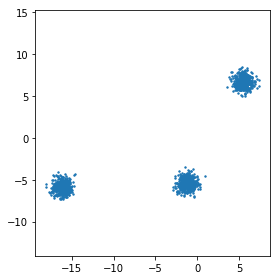

In [2]:
N_SAMPLES = 1500
MIN_CLUSTERS = 2
MAX_CLUSTERS = 4
X, y = datasets.make_blobs(n_samples=N_SAMPLES, # Nombre de punts
                           n_features=2,        # Nombre de dimensions
                           centers=random.randint(MIN_CLUSTERS, MAX_CLUSTERS),
                           center_box=(-20, 20),
                           cluster_std=.6)
print('Hi ha {} punts en {} dimensions (repartits en {} clusters)'.format(X.shape[0], X.shape[1], y.max() + 1))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(X[:,0], X[:,1], s=2)
ax.axis('equal')
plt.tight_layout()

Una tècnica per estimar $k$ és, com s'explica a la teoria:
> Els criteris anteriors (minimització de distàncies intra grup o maximització de distàncies inter grup) poden usar-se per establir un valor adequat per al paràmetre k. Valors k per als quals ja no s'aconsegueixen millores significatives en l'homogeneïtat interna dels segments o l'heterogeneïtat entre segments diferents, haurien de descartar-se.

El que popularment es coneix com *regla del colze*.

Primer cal calcular la suma dels errors quadràtics ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consisteix en la suma de tots els errors (distància de cada punt al seu centroide assignat) al quadrat.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

On $K$ és el nombre de clusters a buscar per *k-means*, $x \in C_i$ són els punts que pertanyen al i-èsim cluster, $c_i$ és el centroide del cluster $C_i$ (al qual pertanty el punt $x$), i $euclidean$ és la [distància euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Aquest procediment realitzat per a cada possible valor $k$, resulta en una funció monòtona decreixent, on l'eix $x$ representa els diferents valors de $k$, i l'eix $y$ el $SSE$. Intuïtivament es podrà observar un significatiu descens de l'error, que indicarà el valor idoni de $k$.

**Es demana realitzar la representació gràfica de la regla del colze al costat de la seva interpretació, utilitzant la llibreria ```matplotlib``` i la implementació en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> càlcul i visualització de la regla del colze.  
</div>

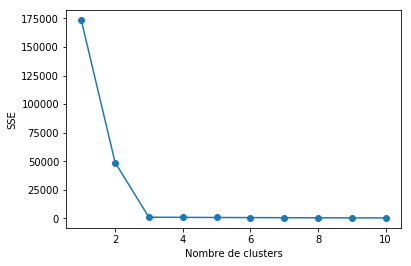

In [3]:
from sklearn.cluster import KMeans

sse = {}
max_k = 10
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=0, max_iter=1000).fit(X)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker="o")
plt.xlabel("Nombre de clusters")
plt.ylabel("SSE")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Què s'interpreta en la gràfica? Com podria millorar-se l'elecció de $k$?  
</div>

Veiem com a mesura que aumenta el valor del nombre de clusters, l'SSE baixa monótonament, i veiem que a partir de *k=3* s'assoleix un valor nul o gairebé nul per l'SSE. Així, per aquest cas, tenim que el valor adient de nombre de clusters és 3, tal com clarament es podia inferir de la representació gràfica anterior.En aquest cas no pot millorar-se l'elecció de *k*, ja que hem assolit el valor d'error zero i això ja no es pot millorar, aquest és el valor d'error més baix que es pot assolir.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>[OPCIONAL] Implementació:</strong> algorisme <i>k-means</i> des de zero.  
</div>

Es desenvolupa l'algorisme *k-means* des de zero, sense fer servir l'algorisme que ja ve implementat a la llibreria *scikit-learn*.

In [4]:
# Definim la classe de l'algoritme k-means.
class K_Means:
    
    # Constructor de la classe.
    def __init__(self, k=3, max_iter=300, tol=0.0001):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
    
    # Funció que desenvolupa l'algoritme.
    def fit(self, dades):
        
        # Definim un diccionari amb els centroides.
        self.centroides = {}
        
        # Inicialitzem els centroides amb els k primers punts que es troben a les dades.
        for i in range(self.k):
            self.centroides[i] = dades[i]
            
        # Iterem tantes vegades com especifica el paràmetre self.max_iter.
        for i in range(self.max_iter):
            
            # Definim un diccionari de clusters.
            self.clusters = {}
            
            # El diccionari conté k parells de clau-valor, on el valor és una llista que contindrà els punts
            # de les dades que s'associen amb cada cluster.
            for i in range(self.k):
                self.clusters[i] = []
                
            # S'avalua cada punt que hi ha a les dades.
            for dada in dades:
                
                # Es calculen les distàncies de cada punt a cada un dels centroides, es tria la distància
                # més petita i s'afegeix el punt a la llista corresponent al cluster que conté el 
                # centroide més proper.
                distancies = [np.linalg.norm(dada - self.centroides[centroide]) for centroide in self.centroides]
                cluster = distancies.index(min(distancies))
                self.clusters[cluster].append(dada)
                
            #prev_centroids = dict(self.centroids)
            
            # Es calcula la posició del nou centroide de cada cluster
            for cluster in self.clusters:
                self.centroides[cluster] = np.average(self.clusters[cluster],axis=0)
                
        # Es retornen els clusters, definits pels seus centroides
        return self.centroides, self.clusters

Un cop definit des de zero l'algorisme, passem a veure un exemple amb dades inventades. L'algorisme ens dona les coordenades dels centroides que defineixen els *k* clusters i els punts que corresponen a cada cluster.

In [5]:
noves_dades = np.array([[4.7, 3.2],
                     [2.5, 1.6],
                     [3.3, 7.9],
                     [3.9, 7.2],
                     [3.0, 0.9],
                     [10.4, 4.1],
                     [5.7, 1.0],
                     [0.8, 8.0],
                   ])


km = K_Means(k=3)
centroides, clusters = km.fit(noves_dades)

print('Centroides:\n',centroides)
print('Clusters: \n', clusters)



Centroides:
 {0: array([6.93333333, 2.76666667]), 1: array([2.75, 1.25]), 2: array([2.66666667, 7.7       ])}
Clusters: 
 {0: [array([4.7, 3.2]), array([10.4,  4.1]), array([5.7, 1. ])], 1: [array([2.5, 1.6]), array([3. , 0.9])], 2: [array([3.3, 7.9]), array([3.9, 7.2]), array([0.8, 8. ])]}


En aquest cas, amb 2 dimensions, és molt senzill inferir el nombre de clústers visualitzant les dades. Però aquest mètode és de gran utilitat quan es compta amb dades d'alta dimensionalitat.

## 2. Clustering amb formes i feature engineering (4 punts)

Però no tots els datasets són com els de l'exercici anterior. Per a aquesta segona part anem a emprar el conjunt de dades següent:

In [6]:
data_circles = ('circles', *datasets.make_circles(n_samples=N_SAMPLES, factor=.5, noise=.05))

On *data_circles* és una tupla amb tres posicions: el nom del dataset i els dos valors retornats per la funció que genera el dataset:

In [7]:
datasets.make_circles?

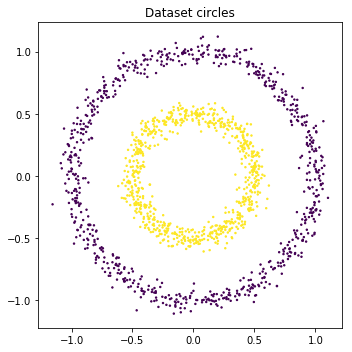

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(data_circles[1][:,0], data_circles[1][:,1], c=data_circles[2], s=2)
ax.set_title('Dataset {}'.format(data_circles[0]))
plt.tight_layout()

### 2 a. Trobant els clusters amb *k-means*

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica la regla del colze per decidir el valor de $k$ en aquest dataset.
</div>

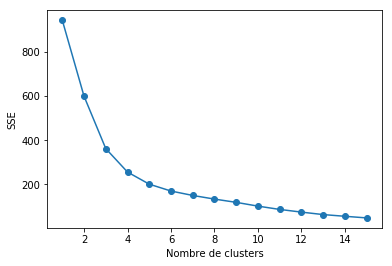

In [9]:
sse = {}
max_k = 15

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=0, max_iter=1000).fit(data_circles[1])
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker="o")
plt.xlabel("Nombre de clusters")
plt.ylabel("SSE")
plt.show()

Veiem com la representació gràfica de l'error segueix la forma típica, monòtona decreixent, però no defineix un colze clarament. Així i tot, si tinc que triar un colze, aquest considero que està al voltant de *k=5*, valor clarament allunyat del valor *k=2* que s'infereix de l'observació de la representació de les dades.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica <i>k-means</i> amb el valor de $k$ escollit per aquest dataset.
<br>
Visualitza el resultat en un <i>scatter plot</i> representant cada clúster amb un color diferent.
</div>

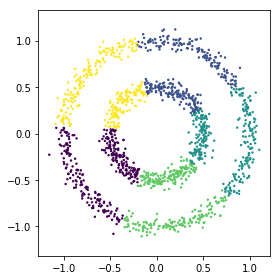

In [10]:
kmeans = KMeans(n_clusters=5, random_state=0, max_iter=1000).fit_predict(data_circles[1])

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(data_circles[1][:,0], data_circles[1][:,1], s=2, c=kmeans)
ax.axis('equal')
plt.tight_layout()

Veiem que amb *k=5* obtenim una separació en 5 clusters que poc o gens representa una separació adient en clusters. Anem a veure què passa si triem *k=2*.

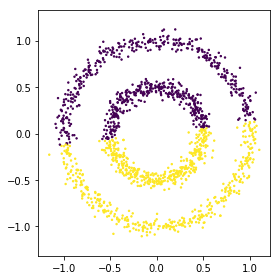

In [11]:
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000).fit_predict(data_circles[1])

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(data_circles[1][:,0], data_circles[1][:,1], s=2, c=kmeans)
ax.axis('equal')
plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.  
</div>

Amb *k=2* veiem que els dos clusters triats no tenen res a veure amb els clusters concèntrics que s'infereixen observant la representació gràfica. Això ens mostra que l'algoritme *k-means* no és adient per separar les dades en clusters quan aquesta separació implica no linealitats. Hauriem de provar altres algoritmes que siguin adients per separacions no lineals.

### 2 b. Més enllà de *k-means*: algorismes basats en la densitat

En aquest apartat es demana aplicar clustering per densitat com [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) al dataset anterior per trobar els dos clusters inicials.

<br>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>

Prova la implementació de [DBSCAN en scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) jugant amb els paràmetres *eps* i *min_samples* per trobar les 2 estructures subjacents (i *outliers*).
</div>

El que faré serà aplicar l'algoritme DBSCAN amb diferents valors d'*eps* i de *min_samples*. 

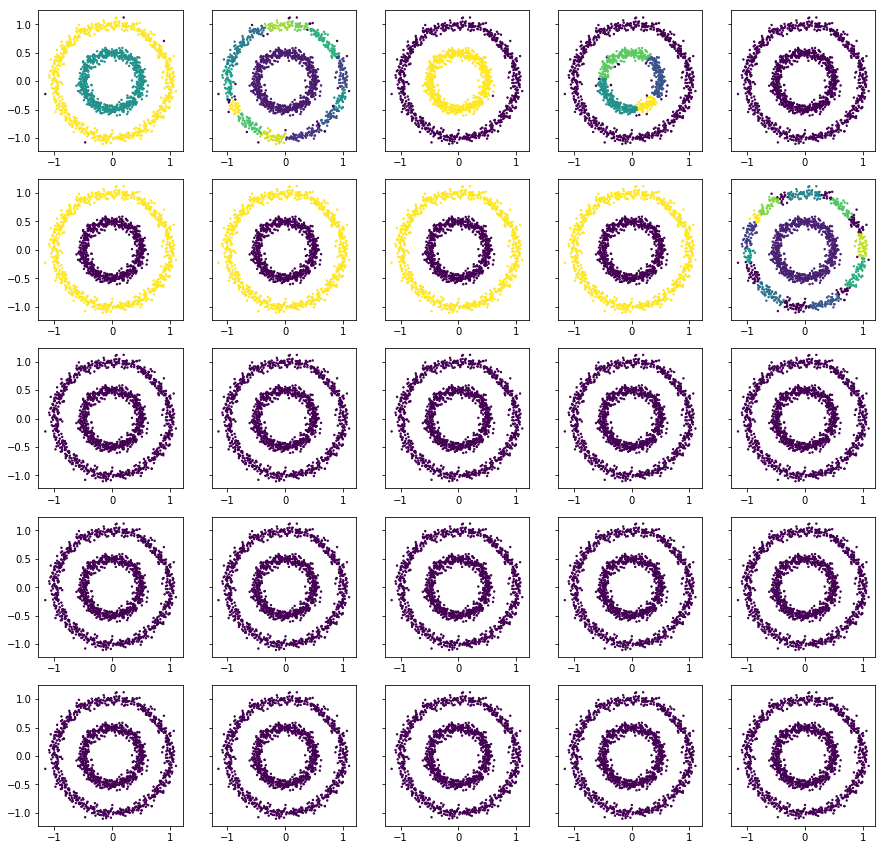

In [12]:
from sklearn.cluster import DBSCAN

fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharey=True)

for eps in range(1, 6):
    for min_samples in range(1, 6):  
        dbscan = DBSCAN(eps=eps/10.0, min_samples=min_samples*10).fit_predict(data_circles[1])
        axs[eps-1, min_samples-1].scatter(data_circles[1][:,0], data_circles[1][:,1], s=2, c=dbscan)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.  
</div>

Veiem com segons quins siguin els valors d'*eps* i de *min_samples* obtenim separacions en diferents nombres de clusters, i dels 25 casos que hem provat n'hi ha 6 en els que la separació és correcta. *eps* és la màxima distància entre dos punts que permet que siguin part d'un mateix veinatge, i *min_samples* és el nombre mínim de dades en un veinatge, si el nombre de punts en un veinatge és menor que *min_samples* llavors DBSCAN no forma un veinatge. Sense importar quina sigui laforma del cluster, DBSCAN enllaça tots els veinatges si estan prou junts, sota la distància *eps*. 

Obtenim resultats molt millors que amb *k-means, i això és així degut a que l'algoritme DBSCAN segueix una metodologia diferent i més adient per datasets amb distribucions més complexes. DBSCAN es basa en la idea de que els clusters són zones amb alta densitat de punts, i per tant aquest algoritme comença explorant l'espai de les dades en totes les direccions i marca la frontera d'un cluster quan la densitat decreix. Les àrees de l'espai de dades amb insuficient densitat de punts són considerades buides, i els punts que s'hi puguin trobar es consideren *outliers*, és a dir, punts caracteritzats per valors inusuals o extranys. 

Amb el resultats obtinguts podem concloure que, efectivament, l'algoritme DBSCAN és apropiat pels casos en que el dataset es distribueix en clusters amb formes *extranyes*, allunyades de la típica forma de bombolla.

### 2 c. Més enllà de *k-means*: algorismes jeràrquics

En aquest apartat es demana visualitzar mitjançant un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcció progressiva dels grups mitjançant un algoritme jeràrquic aglomeratiu (estratègia *bottom-up*). Amb això es pretén trobar un mètode gràfic per determinar el nombre de clústers en cada escenari.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jeràrquic de scipy</a> amb diferents <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o *linkage*</a> permetent identificar els clusters subjacents (mostrant el seu resultat) i el seu dendrograma
</div>

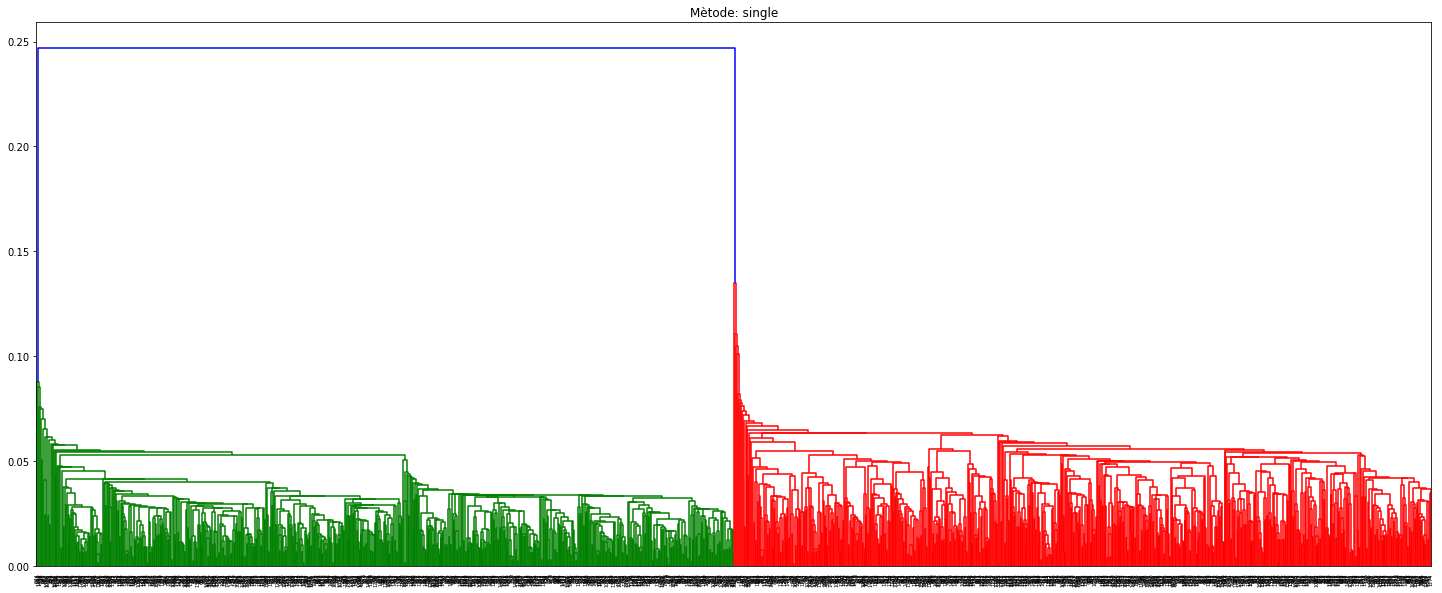

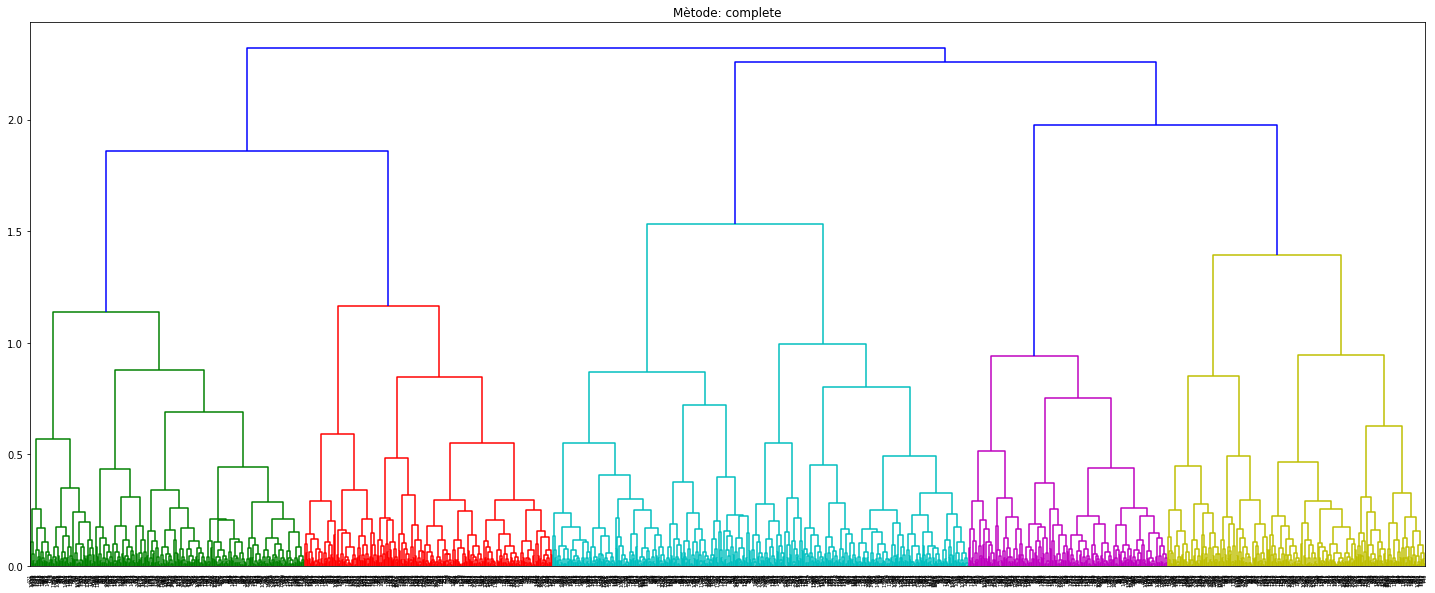

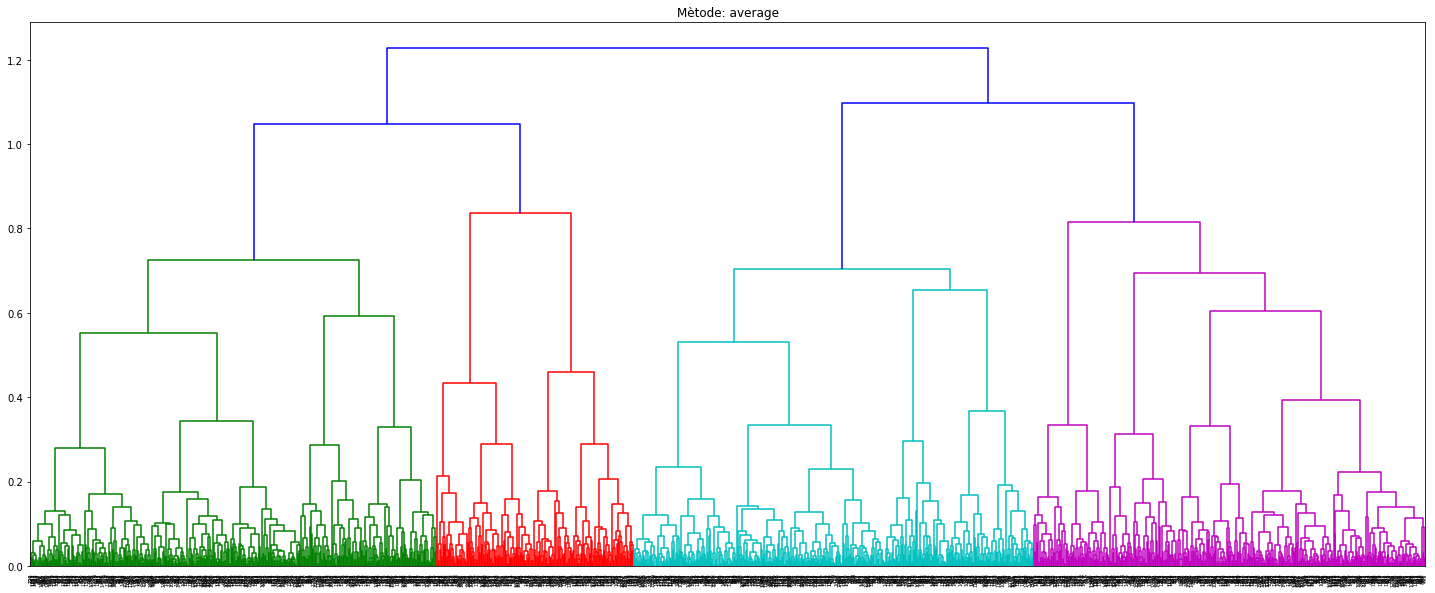

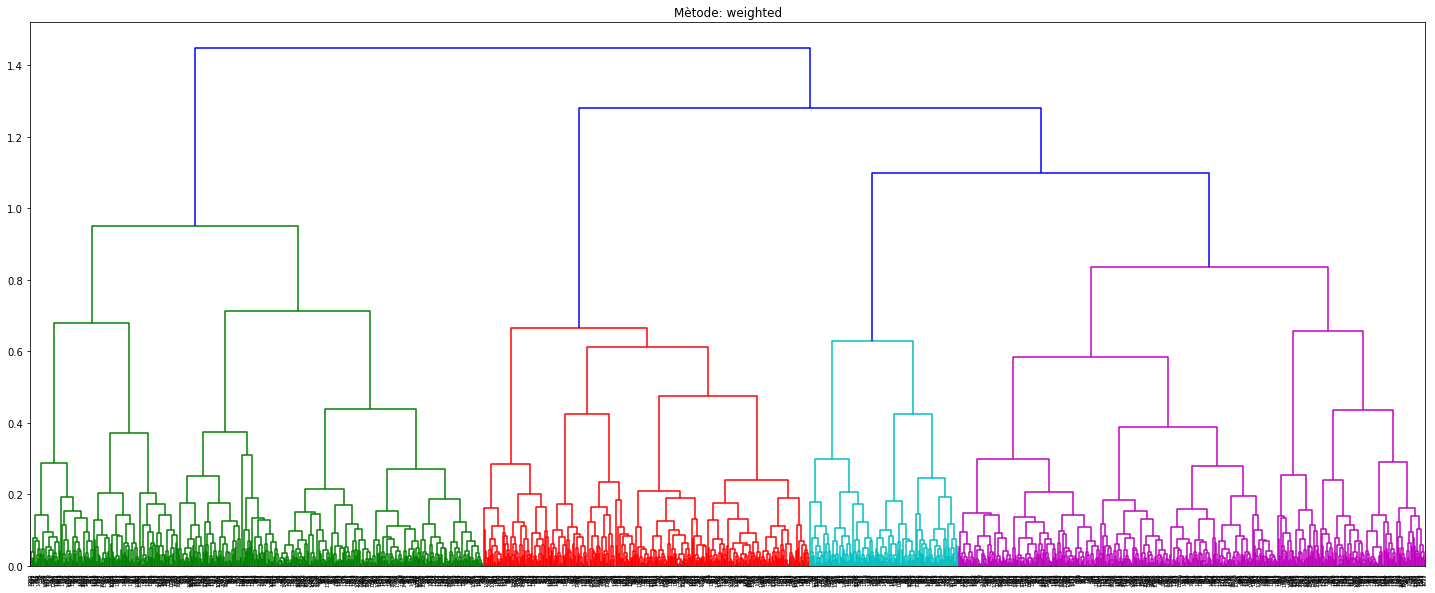

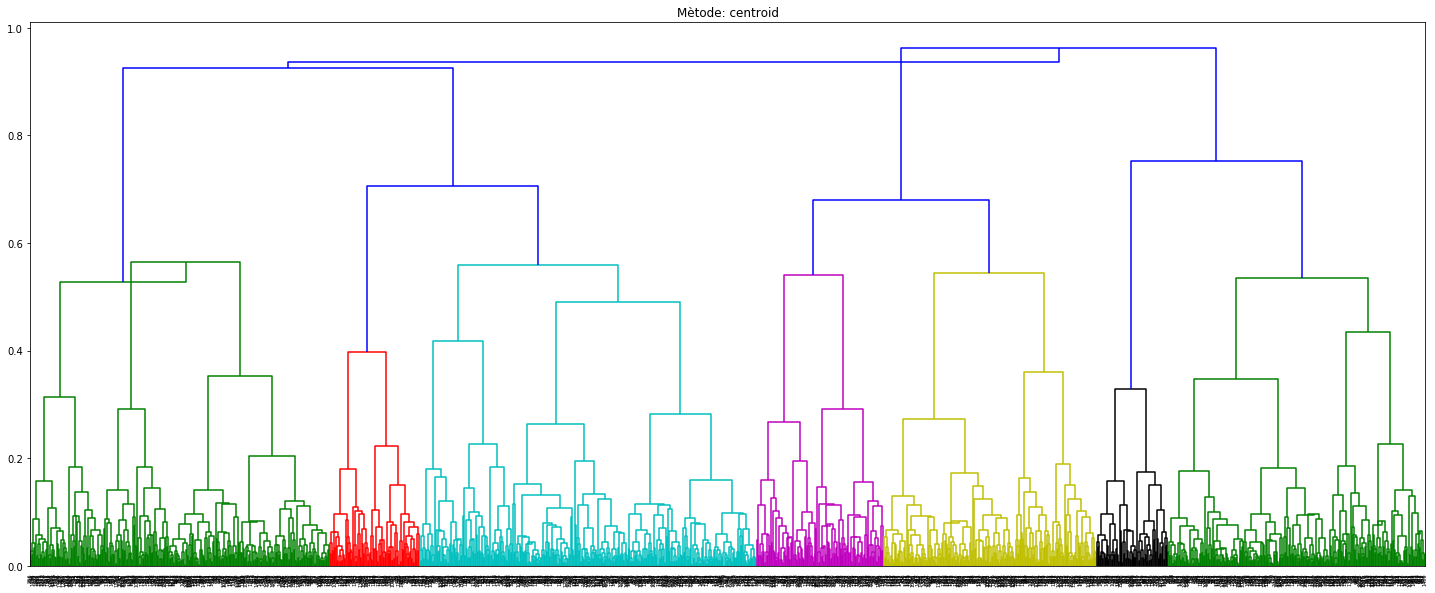

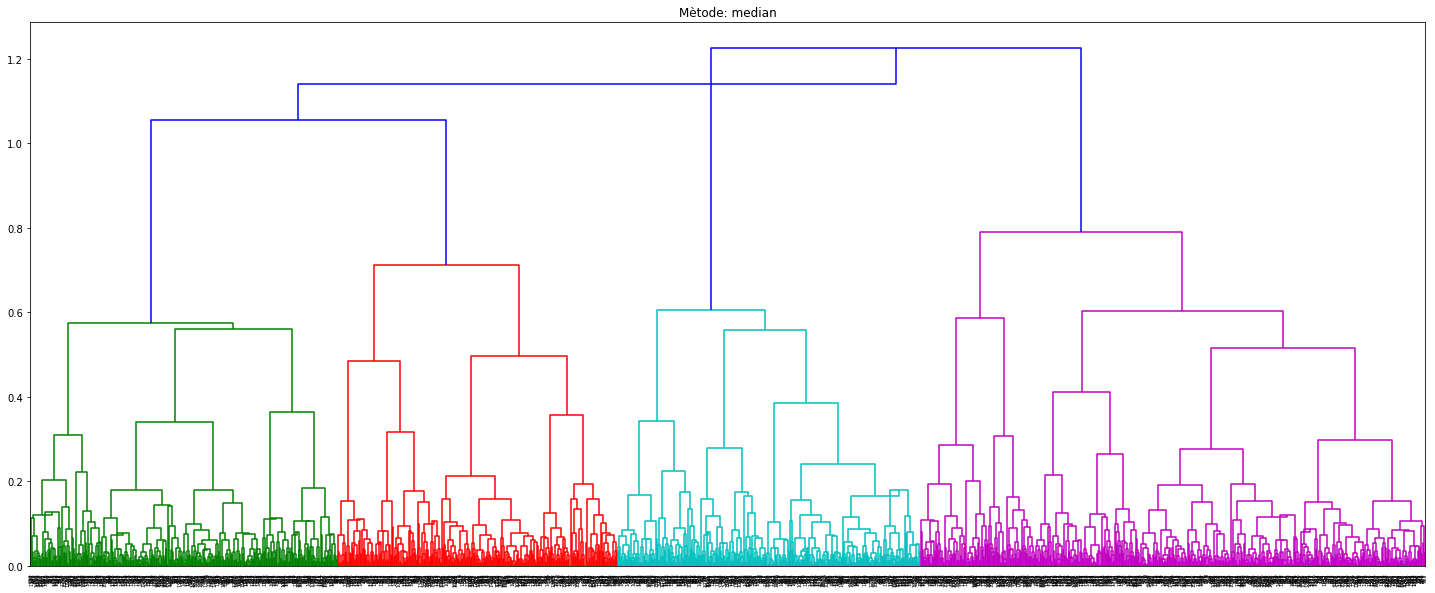

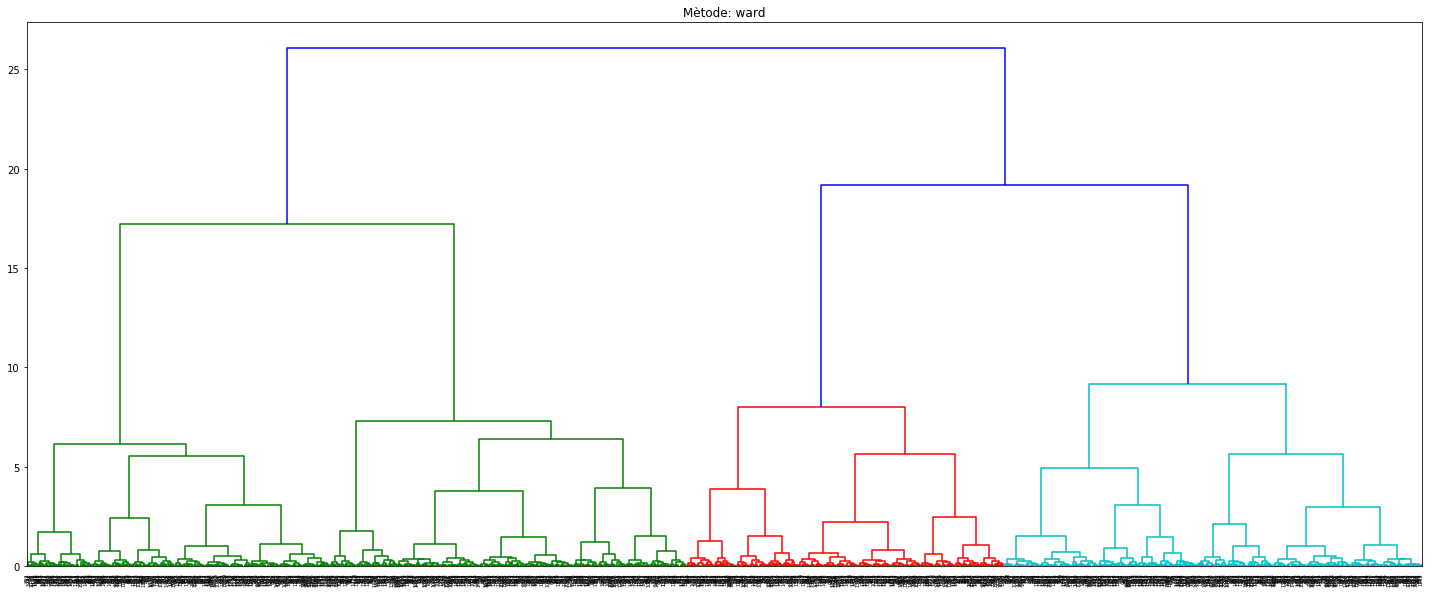

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
for method in linkage_methods:
    X = [i for i in data_circles[1]]
    Z = linkage(X, method=method, metric='euclidean')
    fig = plt.figure(figsize=(25, 10))
    plt.title('Mètode: %s' % method)
    dn = dendrogram(Z)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Interpreta el dendrograma i comenta quin criteri d'enllaç es comporta millor. Per què?
</div>

He provat els 7 diferents criteris d'enllaç i veiem clarament que el que separa d'una manera més definida els dos clusters és el *simple*, que pren com a criteri la distància mínima entre elements dels diferents grups. Es tracta d'un criteri que és apropiat per trobar clusters de forma no el·líptica. Tanmateix, és un algoritme molt sensible al soroll a les dades i pot arribar a provocar l'*efecte cadena*, que consisteix en el fet de que pot arribar a forçar la unió de dos clusters que a priori haurien de mantenir-se ben diferenciats, pel fet de que comparteixen algun element molt proper. Aquest inconvenient no el tenim a les nostres dades, on ambdós clusters estan prou diferenciats i no comarteixen punts propers a ambdós clusters.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.  
</div>

Els diferents criteris d'enllaç tenen els seus avantages i inconvenients, i depenent de la forma del dataset en qüestió cadascun d'ells serà més o menys adient per separar les dades en clusters. Veiem que els diferents criteris d'enllaç donen resultats diferents, alguns seran millors i altres seran pitjors, i aquesta qualificació depen força de la pròpia distribució dels punts a l'espai. En el nostre cas aquesta distribució és l'adient pel criteri d'enllaç *simple* i per això aquest mètode dóna els millors resultats, separant clarament els dos clusters.

### 2 d. *Feature engineering* i agrupament

Alguns dels algorismes anteriors es basen en unes suposicions que no es complien en aquest dataset.
Moltes vegades, enlloc d'optar per algorismes més complexes o que requereixen més poder computacional, es poden transformar les dades per a poder aplicar amb èxit les tècniques més simples. Aquest és un exemple molt clar de *feature engineering*.

<br>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Transforma els punts anteriors del dataset a un nou espai de 2 dimensions:
<ul>
<li>Radi, o distància al punt (0,0)
<li>Angle, respecte al vector (1,0)
</ul>
Per tal que totes les dimensions tinguin el mateix pes, haurem de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">normalitzar-les entre 0 i 1 d'acord amb el seu màxim i mínim</a>.
<br>
<br>
Visualitza els punts del "nou" dataset.
</div>

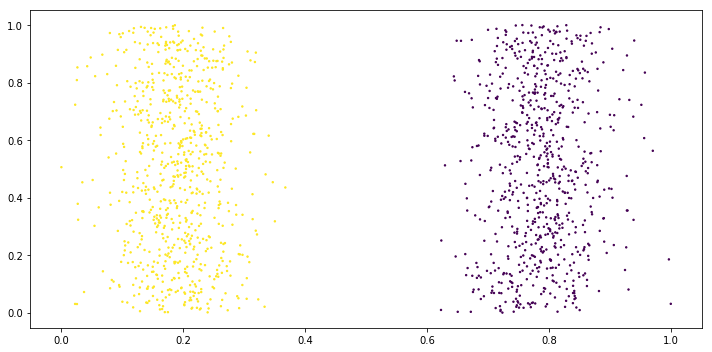

In [14]:
x = data_circles[1][:,0]
y = data_circles[1][:,1]
radi = np.sqrt(x ** 2 + y ** 2)
angle = np.arctan2(y, x)

from sklearn.preprocessing import MinMaxScaler

data = list(zip(radi, angle))
scaler = MinMaxScaler()
scaler.fit(data)
normalized_data = pd.DataFrame(scaler.transform(data))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(normalized_data[0], normalized_data[1], s=2, c=data_circles[2])
plt.tight_layout()


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Què creus que passarà a l'aplicar els algorismes anteriors a aquest "nou" dataset?
</div>

En aquest cas la separació del dos clusters es pot fer mitjançant una separació lineal, per la qual cosa ara haurien de funcionar els algoritmes que abans no han funcionat degut a que no separen bé si no és tracta de separacions lineals.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Aplica cadascun dels algorismes d'agrupament anteriors que no han pogut identificar adequadament els dos clusters originals per tractar de trobar-los en aquest "nou" espai. Ajusta els paràmetres necessaris per facilitar la seva detecció.
<br><br>
Par cada algorisme, visualitza els clusters trobats en 2 imatges:
<ul>
<li> En el "nou" espai (radi i angle).
<li> En l'espai original (posició x i y), però NO amb les etiquetes (pertença a un o altre cluster) obtingudes a l'aplicar els algorismes sobre el dataset original, sinó amb les etiquetes obtingudes al realitzar el clustering en el "nou" espai. A veure si així s'aconsegueixen resoldre els problemes inicials.
</ul>
</div>

Passem a veure l'algoritme *k_means* amb *k=2*.

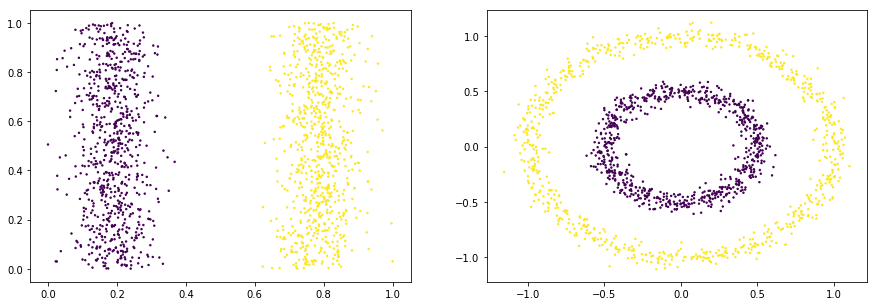

In [15]:
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000).fit_predict(normalized_data)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(normalized_data[0], normalized_data[1], s=2, c=kmeans)
axs[1].scatter(data_circles[1][:,0], data_circles[1][:,1], s=2, c=kmeans)
plt.show()

Ara veiem com l'algoritme *k_means* ha estat capaç de separar perfectament els dos clusters. Passem a veure l'algoritme DBSCAN.

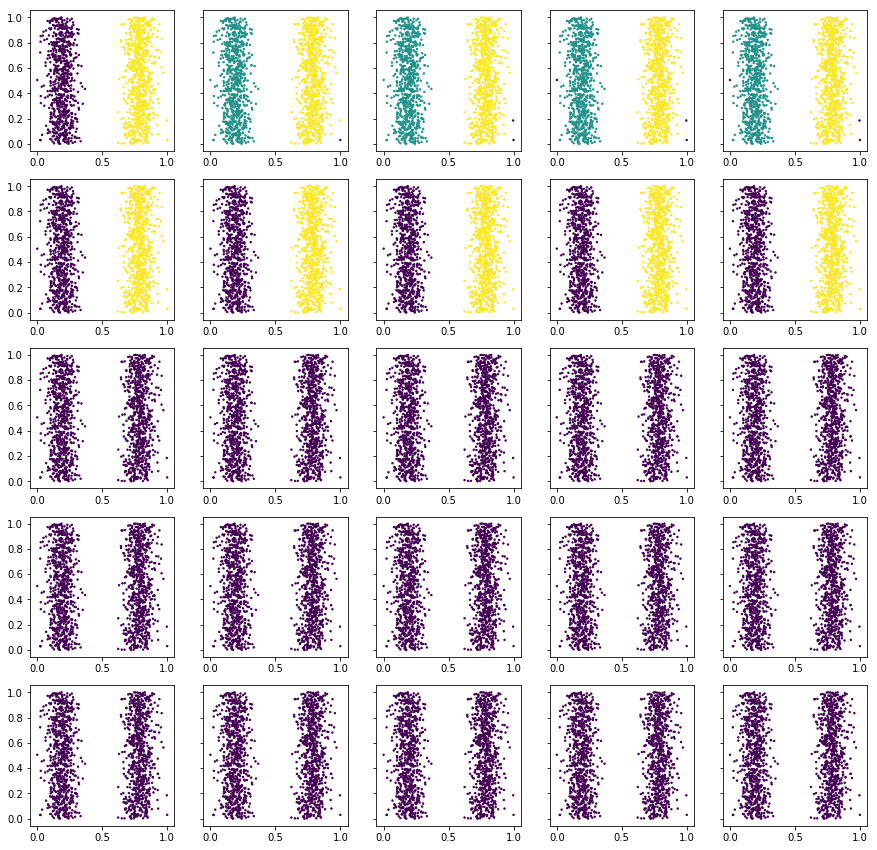

In [16]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharey=True)

for eps in range(1, 6):
    for min_samples in range(1, 6):  
        dbscan = DBSCAN(eps=eps/10.0, min_samples=min_samples*10).fit_predict(normalized_data)
        axs[eps-1, min_samples-1].scatter(normalized_data[0], normalized_data[1], s=2, c=dbscan)

Veiem com ara DBSCAN pot separar els dos clusters en 10 dels 25 casos, enfront dels 6 d'abans. També, doncs, hem obtingut una millora en aquest cas.

## 3. Reducció de dimensionalitat: PCA i t-SNE (1 punt)

En plantejar un problema de classificació amb un dataset de més de tres atributs (dimensions), no es pot fer una visualització clàssica del dataset per entendre les dades. Per això, un dels usos dels mètodes de reducció de dimensionalitat és transformar les dades de més de 4 dimensions a 3 o menys per poder visualitzar-los.

### 3 a. PCA

El [dataset Iris](https://es.wikipedia.org/wiki/Iris_flor_conjunto_de_datos) conté 4 atributs sobre tres tipus de flors.

In [17]:
iris = datasets.load_iris()
X = iris.data   # np.array amb shape (150, 4)
y = iris.target # np.array amb shape (150,)

En excedir les 3 dimensions necessitarem més d'una visualització per entendre les dades.

Per solucionar-ho, una alternativa és usar els [*pair plots*](http://seaborn.pydata.org/generated/seaborn.pairplot.html) que mostren parells de dimensions per intentar donar una visió global a partir d'un [DataFrame](https://pandas.pydata.org/pandas-docs/stable/dsintro.html):

/home/lluis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


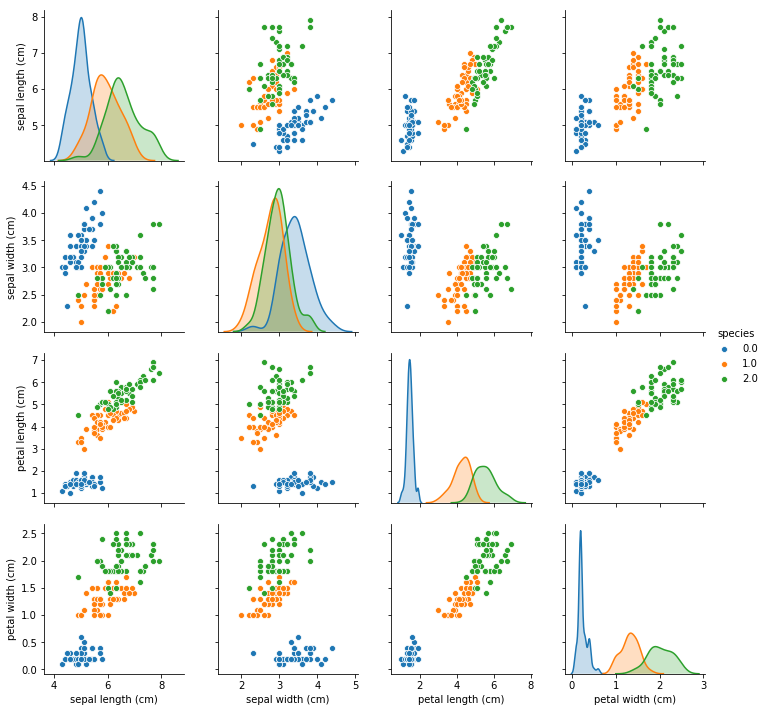

In [18]:
# DataFrame 
iris_df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]), columns=iris.feature_names + ['species'])
sns.pairplot(iris_df, vars=iris.feature_names, hue="species")

Com a alternativa a les múltiples gràfiques que generen els *pair plots*, es planteja utilitzar una tècnica de reducció de dimensionalitat per passar de 4 dimensions a 2. Cal notar que gràfiques com *longitud de pètal* vs *amplada de pètal* mostren certa separabilitat (els 3 tipus de flors estan aparentment separats).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Realitzar una reducció de dimensionalitat amb PCA per passar de 4 dimensions a 2 i crear una visualització on el color dels punts depengui del tipus de flor a la qual pertany.
</div>

Text(0.5, 1.0, 'PCA Scatter Plot')

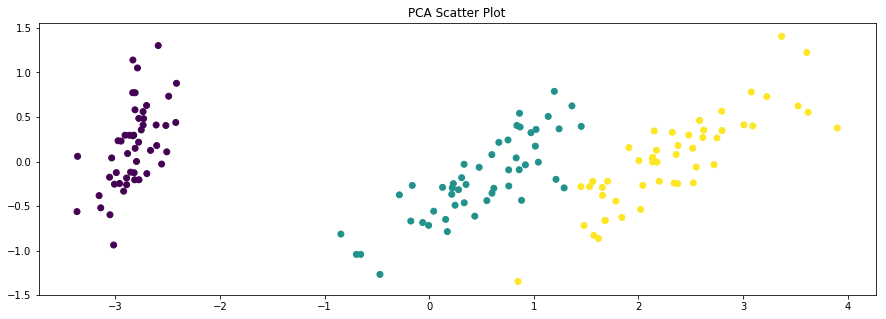

In [19]:
from sklearn.decomposition import PCA

target = pd.Series(iris.target)

pca = PCA(n_components=2)
pca = pca.fit_transform(iris_df) 

plt.figure(figsize = (15,5))
plt.scatter(pca[:,0],pca[:,1], c = target)
plt.title('PCA Scatter Plot')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> El resultat de la reducció de dimensionalitat manté la separabilitat? Era d'esperar? Per què?
</div>

Sí, es manté força la separabilitat. Ja vam veure en la PAC 1 com amb les dades originals obteniem una *accuracy* del 95.80%, i amb les dades reduïdes amb PCA obteniem una *accuracy* del 93.71%, just una mica menys que amb les dades originals. Per tant, era d'esperar que la separabilitat es mantingués.

Això és així degut a que les dades originals tenen atributs que presenten força correlació, i el que fa PCA és triar nous atributs ortogonals que no presenten correlació entre sí. Així, amb menys atributs, obtenim gairebé la mateixa informació.

### 3 b. t-SNE (t-distributed Stochastic Neighbor Embedding)

L'ús de tècniques de reducció de dimensionalitat és de gran utilitat quan aquesta és molt alta. Per exemple, el [dataset Digits](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) conté 1797 imatges de nombres del 0 al 9, de 8 per 8 píxels. Si es pren cada píxel com una dimensió, això es tradueix en què cada mostra té 64 dimensions!

In [20]:
digits = datasets.load_digits()
X = digits.data   # np.array amb shape (1797, 64)
y = digits.target # np.array amb shape (1797,)

Exemple dels 24 primers números de 8 per 8 píxels al costat de la seva etiqueta presents al dataset:

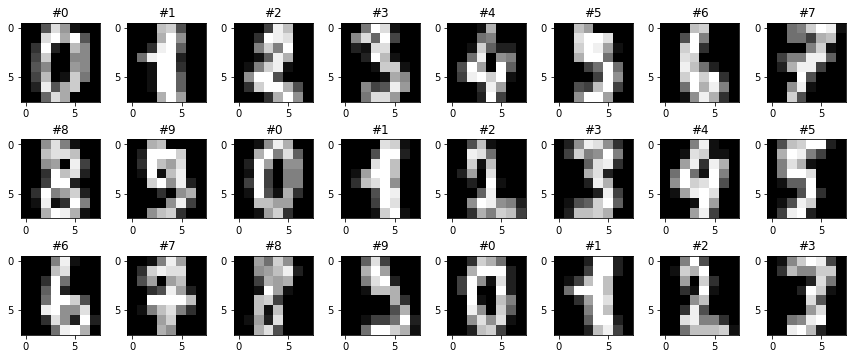

In [21]:
fig, ax = plt.subplots(3, 8, figsize=(12, 5))
for i, axis in zip(range(24), ax.reshape(-1)):
    axis.imshow(X[i,:].reshape(8, 8), cmap='gray')
    axis.set_title('#{}'.format(y[i]))
plt.tight_layout()

Amb un nombre tan elevat de dimensions perd sentit visualitzar el dataset amb un * pair plot * i apareixen altres perills com la [maledicció de la dimensionalitat](https://en.wikipedia.org/wiki/Curse_of_dimensionality).
Per reduir la seva dimensió i així entendre l'estructura de les dades en alta dimensionalitat hi ha diferents alternatives amb resultats molt diferents.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Realitzar una reducció de dimensionalitat amb PCA per passar de 64 dimensions a 2 i crear una visualització on el color dels punts depengui del dígit que pertany.
</div>

Text(0.5, 1.0, 'PCA Scatter Plot')

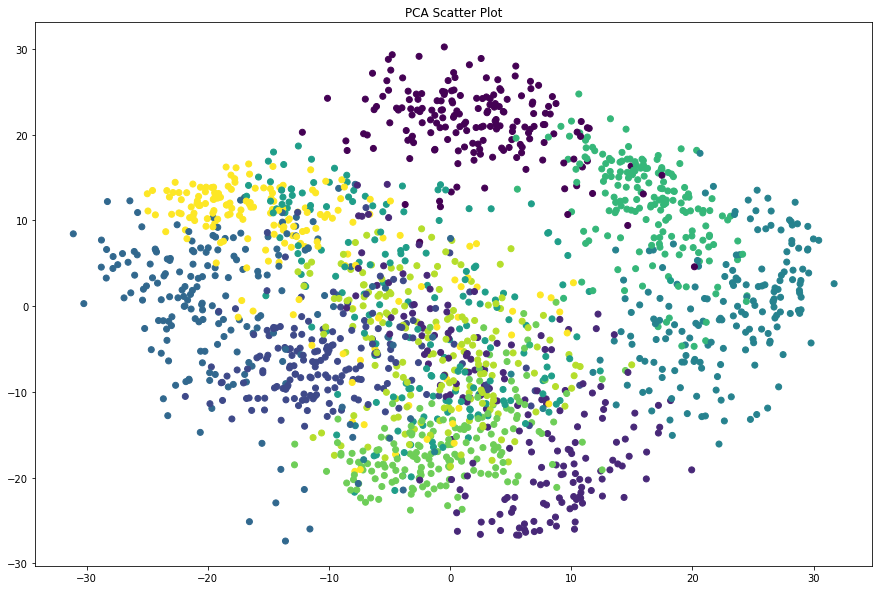

In [22]:
digits_df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]))
target = pd.Series(digits.target)

pca = PCA(n_components=2)
pca = pca.fit_transform(digits_df) 

plt.figure(figsize = (15,10))
plt.scatter(pca[:,0],pca[:,1], c = target)
plt.title('PCA Scatter Plot')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> El resultat de la reducció de dimensionalitat manté la separabilitat? Era d'esperar? Per què?
</div>

Veiem com la separació es manté, però no és perfecte ni de bon troç. Sembla que s'ha perdut separabilitat, segurament degut a que estem visualitzant massa poques dimensions.

L'algoritme [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) desenvolupat per [van der Maaten y Hinton](https://lvdmaaten.github.io/tsne/) difereix de PCA en què no tracta de maximitzar la variància explicada. Intuïtivament, t-SNE tracta que el veïnatge d'un punt en baixa dimensionalitat sigui la mateixa que l'original. Partint d'una localització aleatòria de cada punt, corregeix la seva posició de forma iterativa tractant de minimitzar la distància als seus veïns originals fins a convergir.

Per a això, t-SNE disposa de diversos [paràmetres](https://distill.pub/2016/misread-tsne/) que poden modificar dràsticament el resultat. Pel que recomana conèixer el seu funcionament abans d'aplicar la tècnica.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Realitza una reducció de dimensionalitat amb t-SNE per passar de 64 dimensions a 2 i crea una visualització on el color dels punts depengui del dígit que pertany.
</div>

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.004s...
[t-SNE] Computed neighbors for 1797 samples in 0.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 8.407422
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.568233
[t-SNE] KL divergence after 10000 iterations: 0.682864


Text(0.5, 1.0, 'TSNE Scatter Plot')

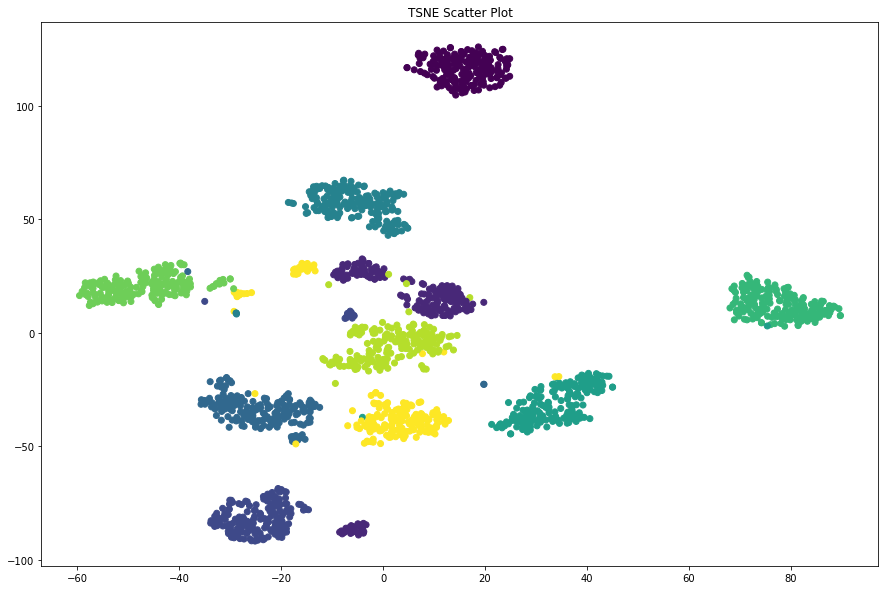

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter= 10000)
tsne = tsne.fit_transform(digits_df)

plt.figure(figsize = (15,10))
plt.scatter(tsne[:,0],tsne[:,1], c = target)
plt.title('TSNE Scatter Plot')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> El resultat de la reducció de dimensionalitat manté la separabilitat? Era d'esperar? Per què?
</div>

Sí, en aquest cas la separabilitat es manté. Era d'esperar, ja que aquest algoritme és una tècnica no-linear de reducció de la dimensionalitat que està molt indicat per transformar dades amb moltes dimensions, com és el nostre cas, per poder visualitzar-les en espais amb baixa dimensionalitat, ben bé de només 2 o 3 dimensions. Al final, es tracta de triar els algoritmes adients depenent de la configuració de les dades.

## 4. Aplicació: agrupació de documents (3 punts)

### 4 a. Càrrega i preparació de les dades

En aquest problema s'utilizarà el dataset [*20 news group*](https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20newsgroups.data.html), amb 20 categories de textos, dels quals se'n seleccionaran 3. L'objectiu és trobar grups de textos (preferiblement de la mateixa categoria) a través de les paraules que els formen.

El primer apartat consisteix en carregar el dataset i preparar les dades (tasca que normalment ocupa entre el 70 i 80% del temps d'un projecte de mineria de dades), en aquest cas els textos.

In [24]:
data = datasets.fetch_20newsgroups(categories=['rec.autos', 'rec.sport.baseball', 'soc.religion.christian'])
texts, targets = data['data'], data['target']

On ```texts``` és una llista amb els articles i ```targets``` és un vector amb l'índex de la categoria a la que pertany cada text.

La neteja del text hauria de convertir el que tenim inicialment:

In [25]:
print(texts[1])

From: aas7@po.CWRU.Edu (Andrew A. Spencer)
Subject: Re: Too fast
Organization: Case Western Reserve University, Cleveland, OH (USA)
Lines: 25
Reply-To: aas7@po.CWRU.Edu (Andrew A. Spencer)
NNTP-Posting-Host: slc5.ins.cwru.edu


In a previous article, wrat@unisql.UUCP (wharfie) says:

>In article <1qkon8$3re@armory.centerline.com> jimf@centerline.com (Jim Frost) writes:
>>larger engine.  That's what the SHO is -- a slightly modified family
>>sedan with a powerful engine.  They didn't even bother improving the
>>*brakes.*
>
>	That shows how much you know about anything.  The brakes on the
>SHO are very different - 9 inch (or 9.5? I forget) discs all around,
>vented in front.  The normal Taurus setup is (smaller) discs front, 
>drums rear.

one i saw had vented rears too...it was on a lot.
of course, the sales man was a fool..."titanium wheels"..yeah, right..
then later told me they were "magnesium"..more believable, but still
crap, since Al is so m uch cheaper, and just as good....


i t

en quelcom semblant a:

```In previous article UUCP wharfie says In article centerline com com Jim Frost writes larger engine That's what the SHO is slightly modified family sedan with powerful engine They didn't even bother improving the *brakes That shows how much you know about anything The brakes on the SHO are very different inch or forget discs all around vented in front The normal Taurus setup is smaller discs front drums rear one saw had vented rears too it was on lot of course the sales man was fool titanium wheels yeah right then later told me they were magnesium more believable but still crap since Al is so uch cheaper and just as good tend to agree tho that this still doesn't take the SHO up to standard for running 130 on regular basis The brakes should be bigger like 11 or so take look at the ones on the Corrados where they have braking regulations DREW```

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Neteja els textos, eliminant:
<ul>
<li> Les línies de l'encapçalament.
<li> Els signes de puntuació.
<li> Els claudàtors, parèntesis i angulars.
<li> Els salts de línia.
<li> Exclamacions i interrogacions.
<li> Els tokens e-mails i de longitud 1. 
<li> Els espais en blanc consecutius.
</ul>
</div>

In [26]:
import re

# Es defineix una funció per netejar els textos
def text_cleaning(text):
    
    # S'el·liminen les línies de capçalera i els salts de línia
    text = " ".join(text.split("\n")[8:])
    
    # S'el·liminen els signes de puntuació, claudàtors, parèntesis, angulars, exclamacions i interrogacions
    punctuations = ".:,;?¿!¡\"\(\)\[\]*><-"
    for punc in punctuations:
        text = text.replace(punc, " ")
    
    # S'el·liminen els tokens e-mails
    text = re.sub(r'[\w\-_+#~!$&\'\.]+@[\w\.-]+', r'', text)
    
    # S'el·liminen els espais en blanc consecutius
    text = re.sub(r'\s+', r' ', text) 
    
    # S'el·liminen els tokens de longitud 1
    text = " ".join([word for word in text.split(" ") if len(word) > 1])
     
    return text

# Es netegen tots els textos
for i, text in enumerate(texts):
    texts[i] = text_cleaning(text)
    
# S'imprimeix com a prova el segon text
print(texts[1])

In previous article UUCP wharfie says In article centerline com com Jim Frost writes larger engine That's what the SHO is slightly modified family sedan with powerful engine They didn't even bother improving the brakes That shows how much you know about anything The brakes on the SHO are very different inch or forget discs all around vented in front The normal Taurus setup is smaller discs front drums rear one saw had vented rears too it was on lot of course the sales man was fool titanium wheels yeah right then later told me they were magnesium more believable but still crap since Al is so uch cheaper and just as good tend to agree tho that this still doesn't take the SHO up to standard for running 130 on regular basis The brakes should be bigger like 11 or so take look at the ones on the Corrados where they have braking regulations DREW


### 4 b. Conversió de textos a vectors

Per tal de trobar grups de textos similars, és necessari convertir cada text a un vector.
Existeixen multitud de maneres de fer-ho, una d'elles és aplicar [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) amb scikit-learn [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), transformant la llista de textos en una [matriu dispersa](https://docs.scipy.org/doc/scipy/reference/sparse.html) amb tantes files com articles i tantes columnes com paraules.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Transforma els textos a vectors amb TF-IDF. Per a reduïr el número de columnes en la matriu evita les *stop words* en anglès i converteix els textos a minúscules.
</div>

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(texts)
print(X.shape)

(1790, 22018)


### 4 c. Reducció de la dimensionalitat

Per tal de visualitzar (i, més endavant, identificar els grups de textos semblants), es reduirà ara la dimensionalitat de la matriu anterior. Així, volem que el número de columnes es redueixi a 2, mentre que el número de files es manté, ja que cada fila és un document.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Utiliza t-SNE per reduïr la dimensionalitat de <i>n</i> columnes (paraules) a 2 dimensions. Utilitza un tamany de la perplexitat alt per tal d'augmentar el veïnatge (al voltant de 100).
</div>

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter= 1000)
tsne = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1790 samples in 2.027s...
[t-SNE] Computed neighbors for 1790 samples in 177.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1790
[t-SNE] Computed conditional probabilities for sample 1790 / 1790
[t-SNE] Mean sigma: 0.540882
[t-SNE] KL divergence after 250 iterations with early exaggeration: 134.842514
[t-SNE] KL divergence after 1000 iterations: 2.123056


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Visualiza mitjançant un scatter plot els punts en 2 dimensions amb un color diferent per a cada classe.
</div>

Text(0.5, 1.0, 'TSNE Scatter Plot')

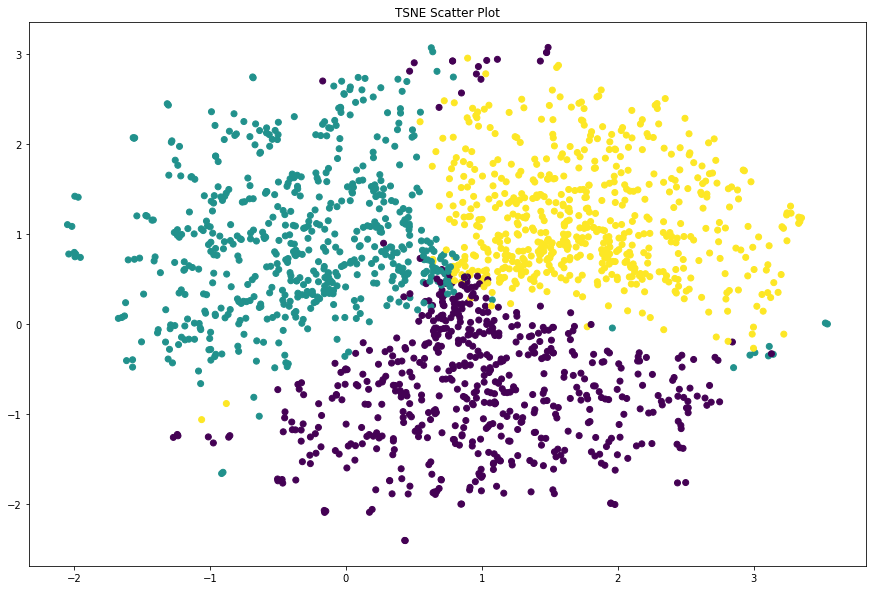

In [29]:
plt.figure(figsize = (15,10))
plt.scatter(tsne[:,0],tsne[:,1], c=targets)
plt.title('TSNE Scatter Plot')

### 4 d. Troba els grups de textos usant diferents algorismes

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Usa <i>k-means</i> (amb <i>k=3</i>) per identificar els 3 grups d'articles i visualitza el resultat.
</div>

Text(0.5, 1.0, 'K-means Scatter Plot')

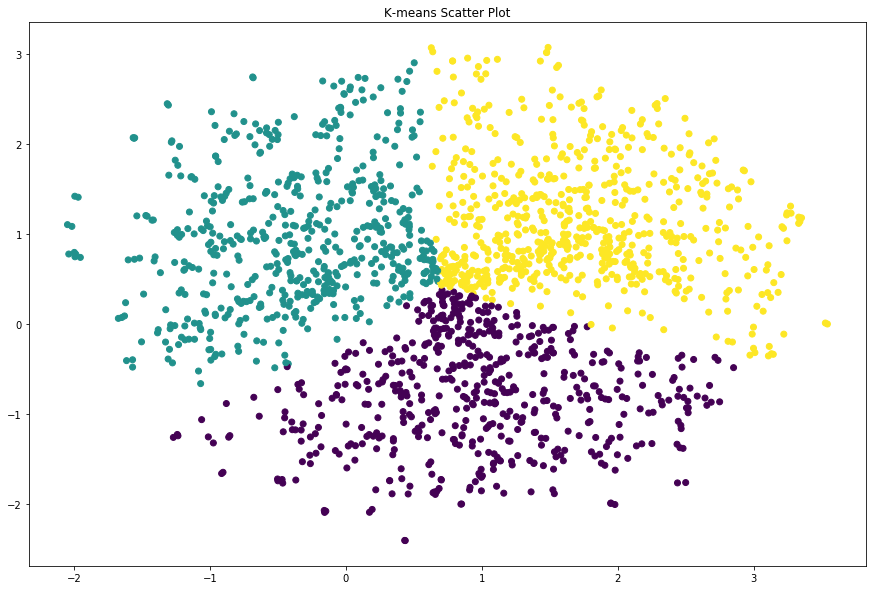

In [30]:
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=1000).fit_predict(tsne)


plt.figure(figsize = (15,10))
plt.scatter(tsne[:, 0],tsne[:, 1], c=kmeans)
plt.title('K-means Scatter Plot')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Has identificat els 3 grups originals? (el color no té perquè coincidir, només ens importa la forma) Per què?
</div>

Sí, s'han identificat els 3 grups originals, no de manera perfecte però bastant semblant. Les característique de *k-means* són prou adients per aquesta mena de problemes.

Per tal d'agrupar els textos tractant de situar els centroides en les regions més denses, [Mean-Shift](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html) segueix un camí desde qualsevol punt de l'espai guiant-se per la densitat de punts fins a trobar un màxim local (dins de la seva <i>bandwidth</i>).

<br>
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> 

Usa <i>Mean-Shift</i>, canviant la <i>bandwidth</i> fins a trobar 3 grups i visualitza el resultat.
</div>

Text(0.5, 1.0, 'Mean-Shift Scatter Plot')

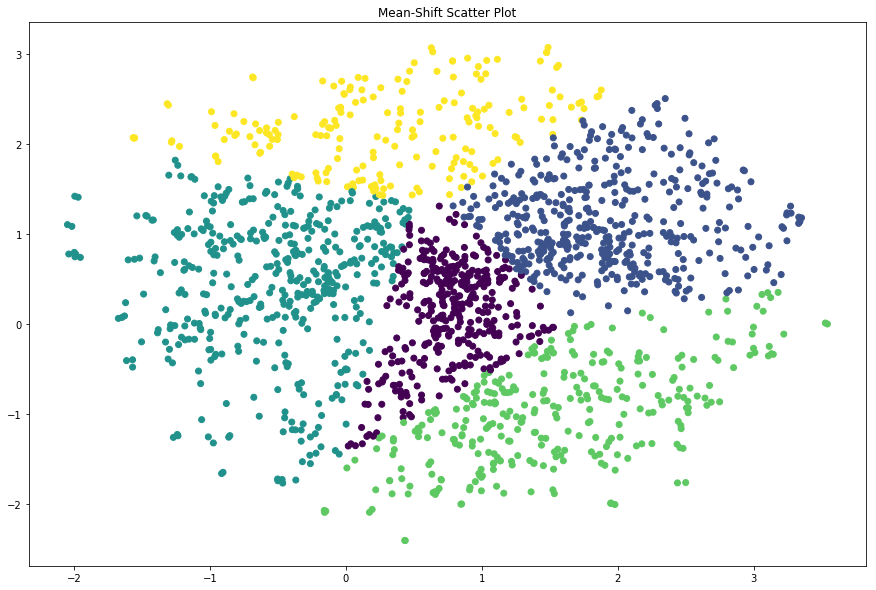

In [31]:
from sklearn.cluster import MeanShift, estimate_bandwidth

#bandwidth = estimate_bandwidth(tsne, quantile=0.2, n_samples=500)
#print(bandwidth)

clustering = MeanShift(bandwidth=0.7).fit_predict(tsne)

plt.figure(figsize = (15,10))
plt.scatter(tsne[:, 0],tsne[:, 1], c=clustering)
plt.title('Mean-Shift Scatter Plot')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Has identificat els 3 grups originals? (el color no té perquè coincidir, només ens importa la forma) Per què?
</div>

He anat canviant el valor del *bandwidth* fins a trobar 3 grups. He vist com per valors molt baixos s'obtenien molts de grups, i a mesura que anava pujant aquest valor cada vegada ne'n trobaven menys. Pel valor *bandwidth=0.7* he trobat els 3 grups. 

Si comparem la representació gràfica obtinguda veiem que els 3 grups obtinguts no coincideixen amb els que hem obtingut anteriorment, encara que s'hi asemblen força. 